In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch import nn
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import confusion_matrix
import random
from PIL import Image

In [2]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

The dataset was created using the Fast ai library, `search_images_ddg`
Here is the code for it:
`

In [ ]:
!pip install fastbook # if you are using google colab, you will need to install fastbook, whereas fastai is pre installed.
from fastai import *
from fastbook import *

bear_types = 'grizzly', 'ice', 'panda' # you can change these to download more types of bears
path = Path('/content/drive/MyDrive/bears')  # You may need to change the path

if not path.exists():
  path.mkdir()
  for bear in bear_types:
    dest = path/bear
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f"{bear} bear")
    download_images(urls=urls, dest=dest)


# Some of the downloads might not be images so to remove those files, following code is executed
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)
fns = get_image_files(path)
fns

In [3]:
# Path of the dataset folder
data_path = r"C:\Users\shobh\Python_Stuff\ML_stuff\bears" # You may need to change the path

In [4]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Setting few image paths to check image transformation
# You may need to change to path to run it
image_path_list = [r'C:\Users\shobh\Python_Stuff\ML_stuff\bears\grizzly\acb1eadb-b9ab-4f4d-bb81-97221a2b5183.jpg',
                   r'C:\Users\shobh\Python_Stuff\ML_stuff\bears\grizzly\9c2bdc09-ec7b-4672-b2bf-c95be60d507b.jpg',
                   r'C:\Users\shobh\Python_Stuff\ML_stuff\bears\grizzly\ea2678c7-51a0-4641-b56e-52f79b0d340e.jpg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..1.9033613].


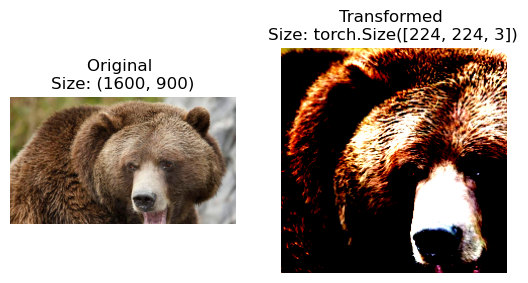

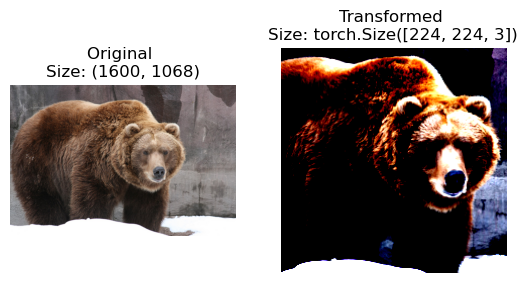

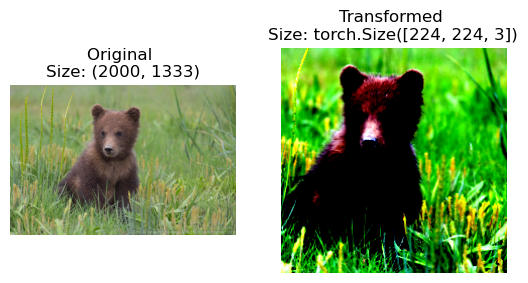

In [6]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")


plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [7]:
# Loading the dataset
data = datasets.ImageFolder(
    root=data_path,
    transform=data_transform,
    target_transform=None
)
data

Dataset ImageFolder
    Number of datapoints: 481
    Root location: C:\Users\shobh\Python_Stuff\ML_stuff\bears
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
# Splitting the dataset into training data and testing data
train_data, test_data = train_test_split(data, test_size=0.2)

In [9]:
len(train_data), len(test_data)

(384, 97)

In [10]:
# Setting up train and test dataloader
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [11]:
classes_name = data.classes
classes_name

['grizzly', 'ice', 'panda']

In [12]:
img, label = train_data[0][0], train_data[0][1]
print(f"Tmage tensor:{img}")
print(f"Image shape:{img.shape}")
print(f"Label:{label}")
print(f"Label name: {classes_name[label]}")

Tmage tensor:tensor([[[-0.8507, -0.8335, -0.7822,  ..., -0.2856, -0.3198, -0.3198],
         [-0.7822, -0.7993, -0.7993,  ..., -0.3027, -0.3369, -0.3541],
         [-0.7479, -0.7822, -0.7993,  ..., -0.3027, -0.2856, -0.3541],
         ...,
         [-0.1657, -0.2513, -0.1657,  ...,  0.6221,  0.5536,  0.6906],
         [-0.0972, -0.1657, -0.1486,  ...,  0.9474,  0.8789,  0.7248],
         [-0.1657, -0.0801, -0.0116,  ...,  0.9817,  0.7762,  0.8447]],

        [[-0.4426, -0.4251, -0.3725,  ...,  0.2752,  0.2402,  0.2402],
         [-0.3725, -0.3901, -0.3901,  ...,  0.2577,  0.2227,  0.2052],
         [-0.3375, -0.3725, -0.3901,  ...,  0.2577,  0.2752,  0.2052],
         ...,
         [-0.2675, -0.3550, -0.2675,  ...,  0.5553,  0.4853,  0.6254],
         [-0.1975, -0.2675, -0.2500,  ...,  0.8880,  0.8179,  0.6604],
         [-0.2675, -0.1800, -0.1099,  ...,  0.9230,  0.6954,  0.7829]],

        [[ 0.0605,  0.0779,  0.1302,  ...,  0.8448,  0.8099,  0.8099],
         [ 0.1302,  0.1128,  0.1

In [13]:
# checking shape of the images and batch size
img_batch, label_batch = next(iter(train_dataloader))
len(img_batch), img_batch.shape

(128, torch.Size([128, 3, 224, 224]))

In [14]:
# Setting up the training step and testing step
def train_step(model, optimizer, loss_fn, epoch, dataloader):
  model.train()
  train_loss, acc = 0, 0
  total_correct = 0
  total_samples = 0

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss +=loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    total_correct += (y_pred_class == y).sum().item()
    total_samples += y.size(0)

  acc = total_correct * 100 / total_samples

  train_loss = train_loss/len(dataloader)
  print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc:2f}")


def test_step(model, loss_fn, epoch, dataloader):
  model.eval()
  test_loss, acc = 0, 0
  total_correct = 0
  total_samples = 0


  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      total_correct += (y_pred_class == y).sum().item()
      total_samples += y.size(0)

    acc = total_correct * 100 / total_samples

    test_loss = test_loss/len(dataloader)
    print(f"Epoch: {epoch} | Test Loss: {loss} | Accuracy: {acc:2f}")
    print("************************")

In [29]:
# Creating Model based on AlexNet Architecture

class BearClassifierAlexNet(nn.Module):
  def __init__(self, dropout=0.5):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, stride=4, kernel_size=11),
        nn.ReLU(),
        nn.MaxPool2d(stride=2, kernel_size=3),

        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(stride=2, kernel_size=3),

        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),

        nn.Conv2d(in_channels=384, out_channels=384, padding=1, kernel_size=3),
        nn.ReLU(),

        nn.Conv2d(in_channels=384, out_channels=256, padding=1, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 3),
    )

  def forward(self, x):
    x = self.conv_block(x)
    x = self.avgpool(x)
    x = self.classifier(x)
    return x


torch.manual_seed(42)
model_0 = BearClassifierAlexNet().to(device)

In [30]:
model_0(img_batch.to(device)).argmax(dim=1)

tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')

In [31]:
# Setting up optimizer and loss function
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

With adjusting the number of epochs, you can get around 90% accuracy with this model :)

Saved model is also available and the code to load it is provided at the end of the notebook

In [32]:
# Training the model
epochs = 50
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for epoch in range(epochs):
  train_step(model=model_0,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epoch=epoch,
             dataloader=train_dataloader)
  test_step(model=model_0,
            loss_fn=loss_fn,
            epoch=epoch,
            dataloader=test_dataloader)

Epoch: 0 | Loss: 1.2379058599472046 | Accuracy: 30.989583
Epoch: 0 | Test Loss: 1.113358974456787 | Accuracy: 29.896907
************************
Epoch: 1 | Loss: 1.119974136352539 | Accuracy: 36.197917
Epoch: 1 | Test Loss: 1.1062347888946533 | Accuracy: 29.896907
************************
Epoch: 2 | Loss: 1.0874621868133545 | Accuracy: 35.937500
Epoch: 2 | Test Loss: 1.1162532567977905 | Accuracy: 29.896907
************************
Epoch: 3 | Loss: 1.035176396369934 | Accuracy: 33.854167
Epoch: 3 | Test Loss: 1.0750529766082764 | Accuracy: 29.896907
************************
Epoch: 4 | Loss: 1.0247639417648315 | Accuracy: 42.708333
Epoch: 4 | Test Loss: 1.0021312236785889 | Accuracy: 37.113402
************************
Epoch: 5 | Loss: 0.9003835916519165 | Accuracy: 43.489583
Epoch: 5 | Test Loss: 1.1700189113616943 | Accuracy: 40.206186
************************
Epoch: 6 | Loss: 0.8581708669662476 | Accuracy: 48.697917
Epoch: 6 | Test Loss: 0.9079567790031433 | Accuracy: 59.793814
******

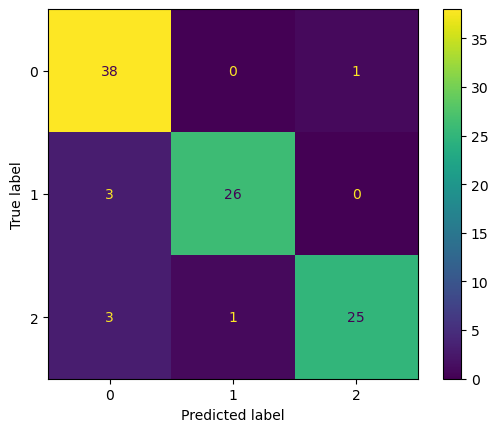

In [33]:
# Plotting Confusion Matrix

y_true = []
y_preds = []

model_0.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)


    y_pred = model_0(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(classes_name)))
disp.plot(cmap="viridis")  # Customize colormap if needed

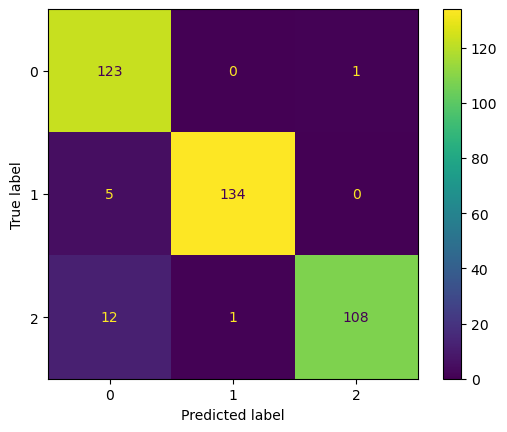

In [34]:
# Plotting Confusion Matrix

y_true = []
y_preds = []

model_0.eval()
with torch.inference_mode():
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)


    y_pred = model_0(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(classes_name)))
disp.plot(cmap="viridis")  # Customize colormap if needed

In [35]:
# 1. Create model directory
MODEL_PATH = Path(r"C:\Users\shobh\Python_Stuff\ML_stuff\models") # You may need to change the path to load the model
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "Bear_Classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [36]:
# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
          f=MODEL_SAVE_PATH)

Saving model to: C:\Users\shobh\Python_Stuff\ML_stuff\models\Bear_Classifier.pth


In [37]:
loaded_model_0 = BearClassifierAlexNet().to(device)

In [38]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\shobh\AppData\Local\Temp\ipykernel_31988\1026707638.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

<All keys matched successfully>